In [621]:
# Pacotes básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pacotes do Scikit-learn para acesso a datasets, preparação, modelagem e avaliação
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Pacote de balanceamento de classes desbalanceadas
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, roc_auc_score, auc  

In [622]:
df = pd.read_csv("treino.csv")
# Informações gerais do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   IDpassageiro   1000 non-null   object
 1   Nome           1000 non-null   object
 2   Deck           1000 non-null   object
 3   NumeroCabine   1000 non-null   int64 
 4   PosicaoCabine  1000 non-null   object
 5   Procedencia    1000 non-null   object
 6   Destino        1000 non-null   object
 7   Idade          1000 non-null   int64 
 8   VIP            1000 non-null   bool  
 9   AllInclusive   1000 non-null   bool  
 10  ServicoCabine  1000 non-null   int64 
 11  Restaurante    1000 non-null   int64 
 12  Shopping       1000 non-null   int64 
 13  SPA            1000 non-null   int64 
 14  ParquedeAguas  1000 non-null   int64 
 15  Sobrevivente   1000 non-null   bool  
dtypes: bool(3), int64(7), object(6)
memory usage: 104.6+ KB


In [623]:
# Data prep
# Codificação de Deck usando Label Encoding
df['Deck'] = df['Deck'].astype('category').cat.codes
# Codificação de PosicaoCabine (P = 1, S = 0)
df['PosicaoCabine'] = df['PosicaoCabine'].map({'P': 1, 'S': 0})

# Convert boolean columns to binary (1 for True, 0 for False)
df['VIP'] = df['VIP'].astype(int)
df['AllInclusive'] = df['AllInclusive'].astype(int)
df['Sobrevivente'] = df['Sobrevivente'].astype(int)

# Aggregate spending columns
df['TotalGasto'] = df[['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas']].sum(axis=1)

# Cria a coluna age_group com faixas etárias
df['GrupoHetario'] = pd.cut(df['Idade'], bins=[-1, 18, 30, 50, 100], labels=["0-18", "19-30", "31-50", "51+"])
df['RangeGasto'] = pd.cut(df['TotalGasto'], bins=[-1, 500, 1000, 2000, 5000, 10000, 30000], labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5001-10000', '10000+'], right=False)

# Converte faixas etárias para números
df['GrupoHetarioCode'] = df['GrupoHetario'].cat.codes
df['RangeGastoCode'] = df['RangeGasto'].cat.codes

# Derived column for same origin and destination
df['MesmaOrigemDestino'] = (df['Procedencia'] == df['Destino']).astype(int)

# Drop original columns if desired
df.drop(['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas'], axis=1, inplace=True)




In [624]:
# Verifique as categorias resultantes
print(df['RangeGastoCode'].value_counts().sort_index())

RangeGastoCode
2      2
3    105
4    340
5    553
Name: count, dtype: int64


In [626]:
print(df['GrupoHetario'].value_counts().sort_index())


GrupoHetario
0-18     238
19-30    155
31-50    230
51+      377
Name: count, dtype: int64


EmGrupo
0    895
1    105
Name: count, dtype: int64


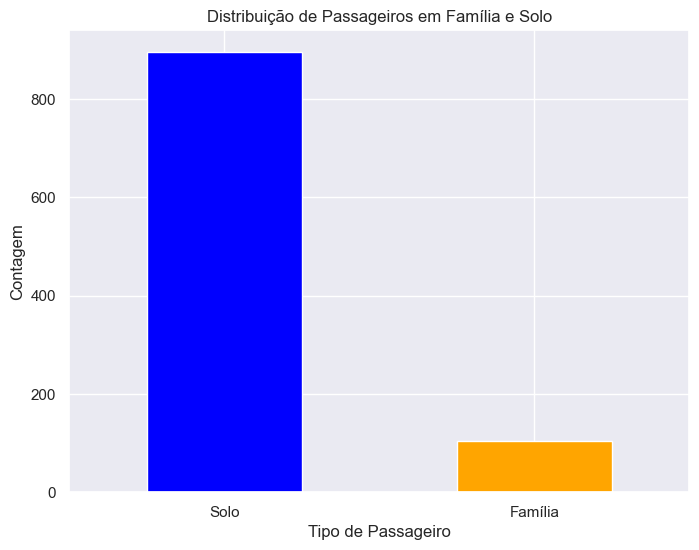

In [627]:
# Passo 1: Separar o ID de grupo e o número do integrante
df[['Grupo', 'Integrante']] = df['IDpassageiro'].str.split('_', expand=True)

# Passo 2: Identificar se o passageiro está em família
# Contar a quantidade de passageiros por grupo
group_counts = df['Grupo'].value_counts()
# Se o grupo tiver mais de um integrante, marcar como família
df['EmGrupo'] = df['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

print(df.EmGrupo.value_counts())

# Passo 3: Criar gráficos
# Gráfico de barras para visualizar passageiros em família ou não
plt.figure(figsize=(8, 6))
df['EmGrupo'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Solo', 'Família'], rotation=0)
plt.title('Distribuição de Passageiros em Família e Solo')
plt.xlabel('Tipo de Passageiro')
plt.ylabel('Contagem')
plt.show()

In [628]:
df["GrupoHetarioCode"] = df["GrupoHetarioCode"].astype(str)
# Colunas que deseja analisar
columns_to_check = ["EmGrupo", "VIP", "AllInclusive", "PosicaoCabine", "Deck", "TotalGasto", "MesmaOrigemDestino"]

for col in columns_to_check:
    print(f"\nRelação entre GrupoHetário e {col}:\n")
    print(df[["GrupoHetarioCode", col, "Sobrevivente"]].groupby(["GrupoHetarioCode", col], as_index=False).mean())


Relação entre GrupoHetário e EmGrupo:

  GrupoHetarioCode  EmGrupo  Sobrevivente
0                0        0      0.535211
1                0        1      0.480000
2                1        0      0.463768
3                1        1      0.470588
4                2        0      0.519231
5                2        1      0.681818
6                3        0      0.550595
7                3        1      0.536585

Relação entre GrupoHetário e VIP:

  GrupoHetarioCode  VIP  Sobrevivente
0                0    0      0.553030
1                0    1      0.500000
2                1    0      0.428571
3                1    1      0.507042
4                2    0      0.558333
5                2    1      0.509091
6                3    0      0.497041
7                3    1      0.591346

Relação entre GrupoHetário e AllInclusive:

  GrupoHetarioCode  AllInclusive  Sobrevivente
0                0             0      0.531532
1                0             1      0.527559
2                1

In [629]:
cols = ["Sobrevivente", "Idade", "NumeroCabine", "Deck", "PosicaoCabine", "EmGrupo", "VIP", "AllInclusive", "RangeGastoCode", "MesmaOrigemDestino", "GrupoHetarioCode"]
train_corr = df[cols].corr()
train_corr

,Sobrevivente,Idade,NumeroCabine,Deck,PosicaoCabine,EmGrupo,VIP,AllInclusive,RangeGastoCode,MesmaOrigemDestino,GrupoHetarioCode
Sobrevivente,1.000000,0.028084,0.011796,-0.007704,-0.015130,0.010194,0.026603,-0.038949,0.045543,-0.043799,0.028771
Idade,0.028084,1.000000,0.004141,-0.030655,0.027304,0.004099,0.089407,-0.032905,-0.033002,-0.011666,0.953204
NumeroCabine,0.011796,0.004141,1.000000,0.015362,-0.023164,-0.031535,0.034778,-0.019533,-0.029860,0.054258,0.017048
Deck,-0.007704,-0.030655,0.015362,1.000000,-0.007834,0.019876,0.074313,0.043093,-0.051361,0.022835,-0.030748
PosicaoCabine,-0.015130,0.027304,-0.023164,-0.007834,1.000000,0.034843,-0.030165,-0.016325,-0.042206,-0.000238,0.036882
EmGrupo,0.010194,0.004099,-0.031535,0.019876,0.034843,1.000000,0.000163,0.010114,0.016102,-0.030388,0.001834
VIP,0.026603,0.089407,0.034778,0.074313,-0.030165,0.000163,1.000000,-0.010203,0.026931,-0.001740,0.085163
AllInclusive,-0.038949,-0.032905,-0.019533,0.043093,-0.016325,0.010114,-0.010203,1.000000,0.004207,-0.058664,-0.032808
RangeGastoCode,0.045543,-0.033002,-0.029860,-0.051361,-0.042206,0.016102,0.026931,0.004207,1.000000,0.017379,-0.028467
MesmaOrigemDestino,-0.043799,-0.011666,0.054258,0.022835,-0.000238,-0.030388,-0.001740,-0.058664,0.017379,1.000000,0.003512


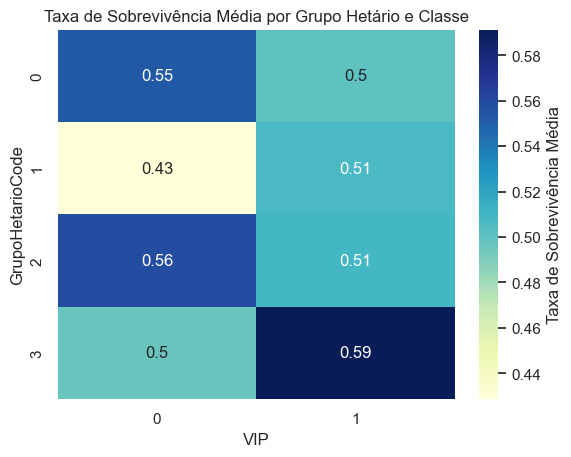

In [630]:
# Exemplo: heatmap de sobrevivência média por grupo etário e VIP
pivot_table = df.pivot_table(values="Sobrevivente", index="GrupoHetarioCode", columns="VIP", aggfunc="mean")
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Grupo Hetário e Classe")
plt.show()

In [631]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(train_corr, annot=True, cmap='coolwarm')
# plt.title('Matriz de Correlação')
# plt.show()

In [632]:
# Calculate the correlation between is_in_family and survived
correlation = df['EmGrupo'].corr(df['Sobrevivente'].corr(df['VIP']))

print(f"Correlation between being in a family and survival rate: {correlation}")

TypeError: unsupported type: <class 'numpy.float64'>

In [529]:
df = df.drop(columns=['IDpassageiro', 'Nome', 'Procedencia', 'Destino', 'NumeroCabine', 'GrupoHetario', ])
df

,Deck,PosicaoCabine,Idade,VIP,AllInclusive,Sobrevivente,TotalGasto,GrupoHetarioCode,MesmaOrigemDestino,Grupo,Integrante,EmGrupo
0,3,1,61,0,1,1,6652,3,0,5647,02,0
1,0,0,31,1,0,1,13875,2,1,0107,01,0
2,6,1,49,1,1,1,14172,2,0,4158,01,0
3,6,0,32,0,1,1,11929,2,0,1316,01,0
4,3,1,5,0,0,1,4625,0,0,9069,05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,6,0,61,1,1,1,13360,3,0,6802,01,0
996,6,1,48,0,1,1,12745,2,0,0313,01,0
997,4,1,41,0,0,1,13739,2,0,9094,01,0
998,2,1,75,0,1,0,17897,3,0,6594,01,0


In [530]:
X = df.drop(["Sobrevivente"], axis=1)
y = df["Sobrevivente"]

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [531]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score



# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# Y_pred = logreg.predict(X_test)
# acc_log = round(logreg.score(X_train, y_train) * 100, 2)
# acc_log


# Escalonando os dados (normalizando para ter média 0 e desvio padrão 1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializando o modelo de Regressão Logística com solver 'saga' e max_iter aumentado
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, C=10)

# Treinando o modelo
logreg.fit(X_train_scaled, y_train)

# Fazendo as previsões
Y_pred = logreg.predict(X_test_scaled)

# Calculando a acurácia no conjunto de treino
acc_log = round(logreg.score(X_train_scaled, y_train) * 100, 2)

# Exibindo a acurácia
print(f'Acurácia no conjunto de treino: {acc_log}%')

Acurácia no conjunto de treino: 55.71%


In [532]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Acurácia: {grid_search.best_score_}")


Melhores parâmetros: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}
Acurácia: 0.5314285714285714


In [533]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)

Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [534]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.53      0.33      0.41       145
           1       0.54      0.73      0.62       155

    accuracy                           0.54       300
   macro avg       0.54      0.53      0.51       300
weighted avg       0.54      0.54      0.52       300



In [535]:
coeff_df = pd.DataFrame(df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
9,Integrante,0.152144
2,VIP,0.138190
5,TotalGasto,0.095981
3,AllInclusive,0.027721
1,Idade,0.010778
0,PosicaoCabine,-0.029001
10,EmGrupo,-0.050703
8,Grupo,-0.093643
4,Sobrevivente,-0.111444
7,MesmaOrigemDestino,-0.116720


In [536]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

74.0

In [537]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score


gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

55.29

In [538]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

100.0

In [539]:
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
acc_decision_tree_train = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de treino: {acc_decision_tree_train}%")
print(f"Acurácia no conjunto de teste: {acc_decision_tree_test}%")

Acurácia no conjunto de treino: 67.71%
Acurácia no conjunto de teste: 53.33%


In [540]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(decision_tree, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Scores de validação cruzada: {scores}")
print(f"Acurácia média da validação cruzada: {scores.mean()}")

Scores de validação cruzada: [0.47857143 0.54285714 0.46428571 0.5        0.47857143]
Acurácia média da validação cruzada: 0.4928571428571429


In [541]:
acc_decision_tree_test = round(decision_tree.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de teste: {acc_decision_tree_test}%")

Acurácia no conjunto de teste: 53.33%


In [542]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
acc_rf_train = round(rf.score(X_train, y_train) * 100, 2)
acc_rf_test = round(rf.score(X_test, y_test) * 100, 2)
print(f"Acurácia no conjunto de treino (Random Forest): {acc_rf_train}%")
print(f"Acurácia no conjunto de teste (Random Forest): {acc_rf_test}%")

Acurácia no conjunto de treino (Random Forest): 79.14%
Acurácia no conjunto de teste (Random Forest): 56.67%


In [543]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Gaussian Naive Bayes',
              'Decision Tree'],
    'Score': [acc_knn, acc_log, 
              acc_rf_train, acc_gaussian,
             acc_decision_tree_train]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,79.14
0,KNN,74.00
4,Decision Tree,67.71
1,Logistic Regression,55.71
3,Gaussian Naive Bayes,55.29
